## Importing MNIST Dataset

In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

### Verifiying Dataset Was Loaded Correctly via MnistDataloader class

In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte') #60,000 training images
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte') #10,000 test images
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

print(training_images_filepath)
print(training_labels_filepath)
print(test_images_filepath)
print(test_labels_filepath)

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray) # values go from 0 (black) to 256
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

MNIST\train-images-idx3-ubyte/train-images-idx3-ubyte
MNIST\train-labels-idx1-ubyte/train-labels-idx1-ubyte
MNIST\t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
MNIST\t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte


### Showing Some of the Images Based on Selected File Path

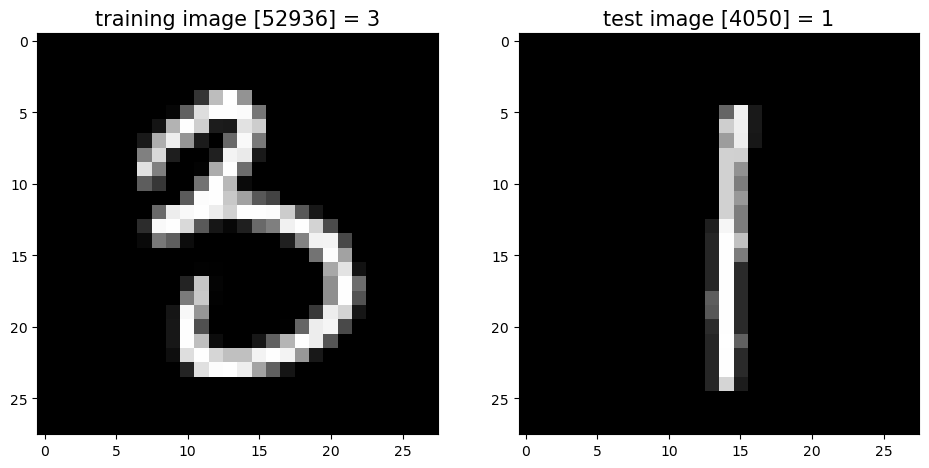

In [3]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 1): # how many random training images you want to show
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 1): # how many random test images you want to show
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Creating Neural Network (2 layers excluding the inputs)

There will be 2 layers. The inputs will be 28 * 28 neurons or 784 in total, the hidden layer will have 300 neurons, and then the output will have 10 neurons representing the likihood of each digit in this classification problem after applying the softmax function to the logit function.

In [4]:
# Defining parameters in neural network

layers = [784, 300, 10]
neurons_input, neurons_l1, neurons_output = layers[0], layers[1], layers[2]
randomGen = np.random.default_rng(seed=42)

W2 = randomGen.random((neurons_output, neurons_l1)) # 10 rows, 300 columns
b2 = randomGen.random((neurons_output, 1))
W1 = randomGen.random((neurons_l1, neurons_input)) #300 rows, 784 columns
b1 = randomGen.random((neurons_l1, 1))

p = [W2, b2, W1, b1]

#Constructing and normalizing mini-batch to be input
def GetMiniBatch(x_train, numInputs): 
    miniBatch = np.zeros((784,numInputs))
    y_miniBatch = np.zeros((10,numInputs))
    for i in range(numInputs):
        r = random.randint(0, 60000 - 1) #we may sample the same images again from another batch but this will be fixed later on
        temp = np.array(x_train[r])
        y_miniBatch[y_train[r],i] = 1 #putting a 1 where the correct label is 
        temp = np.reshape(temp, 784) / 255 #normalize values to be between 0 and 1 or else we cannot exponentiate them for the softmax function
        miniBatch[:,i] = temp
    return miniBatch, y_miniBatch  #each column represents a sample

miniBatch, y_miniBatch = GetMiniBatch(x_train, 1)


In [5]:
"""
#Checking first layer if values are correct
temp = np.matmul(W1, miniBatch)
z1 = temp + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
for j in range(10):
    print("Checking that temp + b1 is correct for index {}, temp:{}, temp + b1: {}, z1: {}".format(j, temp[0][j], temp[0][j] + b1[0], z1[0][j]))
"""


'\n#Checking first layer if values are correct\ntemp = np.matmul(W1, miniBatch)\nz1 = temp + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)\nfor j in range(10):\n    print("Checking that temp + b1 is correct for index {}, temp:{}, temp + b1: {}, z1: {}".format(j, temp[0][j], temp[0][j] + b1[0], z1[0][j]))\n'

In [6]:
# Gradient Checker - with respect to first element in W2 for now
def GradientChecker(miniBatch, y_miniBatch, p, e):
    W2 = p[0]
    b2 = p[1]
    W1 = p[2]
    b1 = p[3]
    
    #J(W2 + e)
    #First Layer
    z1 = np.matmul(W1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
    a1 = sigmoid(z1)
    #Second layer
    W2[0,0] += e
    z2 = np.matmul(W2, a1) + b2 # LOGIT: (10 X 300) X (300 X 100) + (10 X 1) => (10 X 100) 
    #Softmax
    rows, cols = z2.shape
    softmax_denominator = np.zeros((rows,cols))
    for i in range(cols):
        denominator_sum = np.sum(np.exp(z2[:,i]))
        softmax_denominator[:,i] = np.full(rows, denominator_sum)
        
    softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
    loss_1 = Loss(softmax, y_miniBatch)
    
    #J(W2 - e)
    #First Layer
    z1 = np.matmul(W1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
    a1 = sigmoid(z1)
    #Second layer
    W2[0,0] -= e
    z2 = np.matmul(W2, a1) + b2 # LOGIT: (10 X 300) X (300 X 100) + (10 X 1) => (10 X 100) 
    #Softmax
    rows, cols = z2.shape
    softmax_denominator = np.zeros((rows,cols))
    for i in range(cols):
        denominator_sum = np.sum(np.exp(z2[:,i]))
        softmax_denominator[:,i] = np.full(rows, denominator_sum)
    softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
    loss_2 = Loss(softmax, y_miniBatch)

    return (loss_1 - loss_2)/ (2 * e)

In [7]:
a = np.array([[3,4],[5,6]])
b = np.array([[0,1],[1,0]])
a.T

array([[3, 5],
       [4, 6]])

In [8]:
#Cross Entropy Loss for specified minibatch
def Loss(softmax, y_miniBatch):
    # Softmax is (10 by 100) while y_miniBatch is (10 by 100) as well where y_miniBatch holds the one hot encoding
    Loss_all_samples = -np.log(np.diag(np.matmul(y_miniBatch.T, softmax))) ## if the true probability distribution is a one hot encoding then formula reduces to -log(y_correct_label) or the negative log likelihood
    return np.sum(Loss_all_samples) / y_miniBatch.shape[1] # loss over multiple samples is the average of all them

In [16]:
#Foward  and Backward Propagation (assuming 100 sample inputs)
def sigmoid(z):
    return (1/(1 + np.exp(-z)))
            
def sigmoidDeriv(z):
    return (1 - sigmoid(z))

def ForwardAndBackwardProp(miniBatch, y_miniBatch, p, learning_rate, layers):
    W2 = p[0]
    b2 = p[1]
    W1 = p[2]
    b1 = p[3]
    
    #First Layer
    z1 = np.matmul(W1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
    a1 = sigmoid(z1)
    #Second layer
    z2 = np.matmul(W2, a1) + b2 # LOGIT: (10 X 300) X (300 X 100) + (10 X 1) => (10 X 100) 
    #Softmax
    rows, cols = z2.shape
    softmax_denominator = np.zeros((rows,cols))
    for i in range(cols):
        denominator_sum = np.sum(np.exp(z2[:,i]))
        softmax_denominator[:,i] = np.full(rows, denominator_sum)

    softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
    #print("Sum of a column in softmax: {}".format(np.sum(softmax[:,2]))) #checking a column of the final output equals 1
   
    # Backward Prop (Calculating Gradients)
    num_inputs = miniBatch.shape[1]
    localError_l2 = z2 - y_miniBatch # (10 by 100) => derivative of the cross entropy loss with respect to z2 assuming only a softmax is done on z2 is the p - y where is p is the logit and y is the one hot vetor for this classification task 
    dW2 = np.zeros((layers[2], layers[1]))
    db2 = np.zeros((layers[2], 1))
    db1 = np.zeros((layers[1],1))
    dW1 = np.zeros((layers[1],layers[0]))
    
    db2 = (np.sum(localError_l2, axis=1)).reshape((10,1)) #Adding up the localerror along each row
    dW2 = np.matmul(localError_l2, a1.T)
    
    localError_l1 = np.multiply(np.matmul(W2.T, localError_l2), sigmoidDeriv(z1)) #((300 by 10) X (10 by 100)) element_mult (300 by 100)
    db1 = (np.sum(localError_l1, axis=1)).reshape((300,1))
    dW1 = np.matmul(localError_l1, miniBatch.T) #(300 by 100) X (100 by 784)
    #Checking Gradient
    dW2_verified_00 = GradientChecker(miniBatch, y_miniBatch, p, 0.00001)
    print("This is verified: {}, this is acutal: {}".format(dW2_verified_00, dW2[0,0]/num_inputs))
    print("Calculating dW2 another way: {}".format(localError_l2[0,0] * a1[0,0]))
    print(localError_l2)
    print(a1)
    #as of now, the gradients are inccorrect
    
    #Updating Parameters
    derivParam = [dW2, db2, dW1, db1]
    pNew = []
    
    for i in range(len(p)):
        temp = derivParam[i]
        temp /= num_inputs     #Normalizing derivative of loss with respect to different parameters since overall loss = average of the sum of each sample's loss
        pNew.append(p[i] - (learning_rate * temp))
    
    return pNew, softmax

In [17]:
pNew, softmax = ForwardAndBackwardProp(miniBatch, y_miniBatch, p, 0.1, [784,300,10])


This is verified: -0.049496228982093264, this is acutal: 146.7262671358587
Calculating dW2 another way: 146.8252676219906
[[146.82526762 146.82526762 146.82526762 ... 146.82526762 146.82526762
  145.82526762]
 [152.18998053 152.18998053 152.18998053 ... 152.18998053 152.18998053
  152.18998053]
 [149.40472779 149.40472779 149.40472779 ... 149.40472779 149.40472779
  149.40472779]
 ...
 [143.64129714 143.64129714 143.64129714 ... 143.64129714 142.64129714
  143.64129714]
 [157.55228028 158.55228028 158.55228028 ... 158.55228028 158.55228028
  158.55228028]
 [145.8607941  145.8607941  145.8607941  ... 144.8607941  145.8607941
  145.8607941 ]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [19]:
sigmoid(np.array([2,2]))

array([0.88079708, 0.88079708])

In [12]:
Loss(softmax, y_miniBatch)

9.2155108823523

In [13]:
#Putting it all together :), assuming all parameters are initialized
epochs = 100
lossOverTime = []
softmaxOverTime = []

for i in range(epochs):
    miniBatch, y_miniBatch = GetMiniBatch(x_train, 1000)
    pNew, softmax = ForwardAndBackwardProp(miniBatch, y_miniBatch, p, 0.001, [784,300,10])
    tempLoss = Loss(softmax, y_miniBatch)
    W2OverTime.append(pNew[0][0,0])
    
plt.plot(lossOverTime)
plt.title("lossOverTime")
plt.show()
plt.plot(W2OverTime)
plt.title("W2OverTime")

This is verified: -0.049649173661237, this is acutal: 146.7262671358587
Calculating dW2 another way: 146.8252676219906


NameError: name 'W2OverTime' is not defined